In [1]:
from Project.Dataset import Dataset
from Project import utils

In [2]:
import os
import sys
import time
import numpy as np
import imgaug  # https://github.com/aleju/imgaug (pip3 install imgaug)
import json
from PIL import Image
import colorsys
import random
import itertools
import shutil
from tqdm import tqdm
import re

from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
import IPython.display

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils

import zipfile
import urllib.request
import tensorflow as tf
ROOT = os.path.abspath('../project/DATASET')
COCO_ROOT = os.path.join(ROOT, 'coco')
VG_ROOT = os.path.join(ROOT, 'VG')
COCOVG_ROOT = os.path.join(ROOT, 'COCOVG')

In [3]:
def download_coco_anns(dataDir, dataType, dataYear):
    annDir = "{}/annotations".format(dataDir)
    if dataType == "minival":
        annZipFile = "{}/instances_minival2014.json.zip".format(dataDir)
        annFile = "{}/instances_minival2014.json".format(annDir)
        annURL = "https://dl.dropboxusercontent.com/s/o43o90bna78omob/instances_minival2014.json.zip?dl=0"
        unZipDir = annDir
    elif dataType == "valminusminival":
        annZipFile = "{}/instances_valminusminival2014.json.zip".format(dataDir)
        annFile = "{}/instances_valminusminival2014.json".format(annDir)
        annURL = "https://dl.dropboxusercontent.com/s/s3tw5zcg7395368/instances_valminusminival2014.json.zip?dl=0"
        unZipDir = annDir
    else:
        annZipFile = "{}/annotations_trainval{}.zip".format(dataDir, dataYear)
        annFile = "{}/instances_{}{}.json".format(annDir, dataType, dataYear)
        annURL = "http://images.cocodataset.org/annotations/annotations_trainval{}.zip".format(dataYear)
        unZipDir = dataDir
    # Download annotations if not available locally
    if not os.path.exists(annDir):
        os.makedirs(annDir)
    if not os.path.exists(annFile):
        if not os.path.exists(annZipFile):
            print("Downloading zipped annotations to " + annZipFile + " ...")
            with urllib.request.urlopen(annURL) as resp, open(annZipFile, 'wb') as out:
                shutil.copyfileobj(resp, out)
            print("... done downloading.")
        print("Unzipping " + annZipFile)
        with zipfile.ZipFile(annZipFile, "r") as zip_ref:
            zip_ref.extractall(unZipDir)
        print("... done unzipping")
    print("Will use annotations in " + annFile)

In [4]:
download_coco_anns(COCO_ROOT, 'train', '2014')
download_coco_anns(COCO_ROOT, 'val', '2017')
coco_train = COCO("{}/annotations/instances_{}{}.json".format(COCO_ROOT, "train", '2014'))
coco_val = COCO("{}/annotations/instances_{}{}.json".format(COCO_ROOT, "val", '2017'))

Will use annotations in /Users/liyiming/Desktop/Birmingham Life/project/DATASET/coco/annotations/instances_train2014.json
Will use annotations in /Users/liyiming/Desktop/Birmingham Life/project/DATASET/coco/annotations/instances_val2017.json
loading annotations into memory...
Done (t=13.14s)
creating index...
index created!
loading annotations into memory...
Done (t=0.58s)
creating index...
index created!


In [5]:
class_ids_train = sorted(coco_train.getCatIds())
class_ids_val = sorted(coco_val.getCatIds())
image_ids_train = list(coco_train.imgs.keys())
image_ids_val = list(coco_val.imgs.keys())

In [6]:
with open(os.path.join(VG_ROOT, 'image_data.json'), 'r') as load_f:
    VG_img_detail = json.load(load_f)

In [7]:
VG_img_detail[0]

{'coco_id': None,
 'flickr_id': None,
 'height': 600,
 'image_id': 1,
 'url': 'https://cs.stanford.edu/people/rak248/VG_100K_2/1.jpg',
 'width': 800}

In [8]:
COCO_img_id = []
VG_img_id = []
for i in VG_img_detail:
    if i['coco_id']:
        COCO_img_id.append(i['coco_id'])
        VG_img_id.append(i['image_id'])

    
print('Total num of valid ids: {}'.format(len(COCO_img_id)))
valid_train = list(set(COCO_img_id).intersection(set(image_ids_train)))
valid_val = list(set(COCO_img_id).intersection(set(image_ids_val)))

Total num of valid ids: 51498


In [9]:
with open(os.path.join(VG_ROOT, 'region_descriptions.json'), 'r') as load_f:
    VG_region_description = json.load(load_f)

In [10]:
VG_i_detail = []
VG_r_des = []
for i, des in enumerate(VG_region_description):
    if 20 <= len(des['regions']) <= 50:
        filtered_regions = []
        for region in des['regions']:
            phrase = region['phrase']
            words = phrase.split(" ")
            if 1 <= len(words) <= 10:
                filtered_regions.append(region)
        if len(filtered_regions) == 0:
            continue
        des['regions'] = filtered_regions
        VG_r_des.append(des)
        VG_i_detail.append(VG_img_detail[i])

len(VG_i_detail), len(VG_r_des)

(91725, 91725)

In [11]:
VG_i_detail[34532]['image_id'], VG_r_des[34532]['id'], len(VG_r_des[0]['regions'])

(2379252, 2379252, 46)

In [28]:
# Generate new dataset
print('Start generating dataset...')
train_ann = []
val_ann = []
for index, i in tqdm(enumerate(VG_i_detail)):
    if i['coco_id'] and i['coco_id'] in valid_train:
        if os.path.exists(os.path.join(VG_ROOT, 'VG_100K/{}.jpg'.format(i['image_id']))):
            ann_coco = coco_train.loadAnns(coco_train.getAnnIds(
                    imgIds=i['coco_id'], catIds=class_ids_train, iscrowd=None))
            
            uncrowd = []
            for ic in ann_coco:
                if not ic['iscrowd']:
                    uncrowd.append(ic)
            
            if len(uncrowd) == 0:
                continue
            
            coco_size = [coco_train.imgs[i['coco_id']]['width'], 
                         coco_train.imgs[i['coco_id']]['height']]
            vg_size = [i['width'], i['height']]
            scale = coco_size[0] / vg_size[0]
            ann = {}
            ann['scale'] = scale
            ann['image_id'] = i['coco_id']
            ann['coco_ann'] = uncrowd
            ann['image_width'] = coco_size[0]
            ann['image_height'] = coco_size[1]
            j = VG_r_des[index]
#             for j in VG_r_des:
            if i['image_id'] == j['id']:
                ann_vg = j
                regions = ann_vg['regions']
                scaled_regions = []
                for region in regions:
                    r = region.copy()
                    r['x'] = r['x'] * scale
                    r['y'] = r['y'] * scale
                    r['width'] = r['width'] * scale
                    r['height'] = r['height'] * scale
                    res = re.sub(r'[^\w\s]', '', r['phrase']) 
                    r['phrase'] = '<start> ' + res + ' <end>'
                    scaled_regions.append(r)
                ann['vg_ann'] = scaled_regions
            train_ann.append(ann)
                        
            img_train = Image.open(os.path.join(VG_ROOT, 'VG_100K/{}.jpg'.format(i['image_id'])))
            img_train = img_train.resize(coco_size)
            img_train.save(os.path.join(COCOVG_ROOT, 'train/{}.jpg'.format(i['coco_id'])))
            
#             shutil.copyfile(os.path.join(VG_ROOT, 'VG_100K/{}.jpg'.format(i['image_id'])),
#                             os.path.join(COCOVG_ROOT, 'train/{}.jpg'.format(i['image_id'])))
#             os.rename(os.path.join(COCOVG_ROOT, 'train/{}.jpg'.format(i['image_id'])), 
#                       os.path.join(COCOVG_ROOT, 'train/{}.jpg'.format(i['coco_id'])))
    if i['coco_id'] and i['coco_id'] in valid_val:
        if os.path.exists(os.path.join(VG_ROOT, 'VG_100K/{}.jpg'.format(i['image_id']))):
            ann_coco = coco_val.loadAnns(coco_val.getAnnIds(
                    imgIds=i['coco_id'], catIds=class_ids_val, iscrowd=None))
            
            uncrowd = []
            for ic in ann_coco:
                if not ic['iscrowd']:
                    uncrowd.append(ic)
            
            if len(uncrowd) == 0:
                continue
            
            coco_size = [coco_val.imgs[i['coco_id']]['width'], 
                         coco_val.imgs[i['coco_id']]['height']]
            vg_size = [i['width'], i['height']]
            scale = coco_size[0] / vg_size[0]
            ann = {}
            ann['scale'] = scale
            ann['image_id'] = i['coco_id']
            ann['coco_ann'] = uncrowd
            ann['image_width'] = coco_size[0]
            ann['image_height'] = coco_size[1]
            j = VG_r_des[index]
#             for j in VG_r_des:
            if i['image_id'] == j['id']:
                ann_vg = j
                regions = ann_vg['regions']
                scaled_regions = []
                for region in regions:
                    r = region.copy()
                    r['x'] = r['x'] * scale
                    r['y'] = r['y'] * scale
                    r['width'] = r['width'] * scale
                    r['height'] = r['height'] * scale
                    res = re.sub(r'[^\w\s]', '', r['phrase']) 
                    r['phrase'] = '<start> ' + res + ' <end>'
                    scaled_regions.append(r)
                ann['vg_ann'] = scaled_regions    
            val_ann.append(ann)
                        
            img_val = Image.open(os.path.join(VG_ROOT, 'VG_100K/{}.jpg'.format(i['image_id'])))
            img_val = img_val.resize(coco_size)
            img_val.save(os.path.join(COCOVG_ROOT, 'val/{}.jpg'.format(i['coco_id'])))
            
            
            
#             shutil.copyfile(os.path.join(VG_ROOT, 'VG_100K/{}.jpg'.format(i['image_id'])),
#                             os.path.join(COCOVG_ROOT, 'val/{}.jpg'.format(i['image_id'])))
#             os.rename(os.path.join(COCOVG_ROOT, 'val/{}.jpg'.format(i['image_id'])), 
#                       os.path.join(COCOVG_ROOT, 'val/{}.jpg'.format(i['coco_id'])))
print('Done...')
print(len(val_ann))
print(len(train_ann))
# print('Start saving annotations...')
# train_ann_path = os.path.join(COCOVG_ROOT, 'train_ann.json')
# val_ann_path = os.path.join(COCOVG_ROOT, 'val_ann.json')
# with open(train_ann_path, 'w') as f:
#     json.dump(train_ann, f)
# with open(val_ann_path, 'w') as f:
#     json.dump(val_ann, f)
# print('Done...')

1849it [00:00, 18471.17it/s]

Start generating dataset...


91725it [07:15, 210.38it/s] 

Done...
1115
17190


In [29]:
file = open(os.path.join(COCOVG_ROOT, 'captions.txt'), 'a+')
counts = {}
texts = []
for ann in train_ann:
    regions = ann['vg_ann']
    for region in regions:
        phrase = region['phrase']
        texts.append(phrase)
        file.write(phrase + '\n')
        words = phrase.split(" ")
        for word in words:
            counts[word] = counts.get(word, 0) + 1
for ann in val_ann:
    regions = ann['vg_ann']
    for region in regions:
        phrase = region['phrase']
        texts.append(phrase)
        file.write(phrase + '\n')
        words = phrase.split(" ")
        for word in words:
            counts[word] = counts.get(word, 0) + 1
file.close()

In [30]:
counts.pop('')
num = 0
unuse = []
for key in counts.keys():
    if counts[key] < 15:
        num += counts[key]
        unuse.append(key)
for key in unuse:
    counts.pop(key)
counts['<UNK>'] = num
print("<UNK> num is {}".format(num))


countsList = list(counts.items())
countsList.sort(key=lambda x:x[1], reverse=True)
print("Totoal words: {}".format(len(countsList)))

for i in range(100):
    word, count = countsList[i]
    print('{0:<10}{1:>5}'.format(word,count))

<UNK> num is 79017
Totoal words: 6275
<start>   860034
<end>     860034
the       298380
a         292013
on        222521
of        163312
is        118934
in        117913
white     95939
<UNK>     79017
black     55935
A         54793
and       51574
blue      44568
man       43914
with      43884
The       43401
wearing   35408
red       32236
green     30714
brown     26787
sky       23925
are       21759
person    21531
this      19568
woman     18988
wall      18877
shirt     18736
table     17734
water     17611
yellow    17263
to        16743
train     16726
building  15945
grass     15838
sign      15372
has       15361
ground    14909
light     14496
clouds    14314
window    13652
plate     13592
tree      13588
top       12830
side      12636
an        12605
part      11527
head      11509
two       11491
front     11404
street    10586
large     10549
small     10426
standing  10233
behind    10065
color      9996
holding    9944
orange     9752
bus        9639
hand      

In [31]:
wd = {}
for words, count in countsList:
    wd[words] = count
words_dict = os.path.join(COCOVG_ROOT, 'words_dict.json')
with open(words_dict, 'w') as f:
    json.dump(wd, f)

In [32]:
texts[1]

'<start> Green couch in the room <end>'

In [33]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000, oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

In [34]:
tokenizer.fit_on_texts(texts)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [35]:
tokenizer.word_index

{'<unk>': 1,
 '<start>': 2,
 '<end>': 3,
 'a': 4,
 'the': 5,
 'on': 6,
 'of': 7,
 'is': 8,
 'in': 9,
 'white': 10,
 'black': 11,
 'man': 12,
 'and': 13,
 'blue': 14,
 'with': 15,
 'red': 16,
 'wearing': 17,
 'green': 18,
 'brown': 19,
 'this': 20,
 'person': 21,
 'sky': 22,
 'woman': 23,
 'are': 24,
 'yellow': 25,
 'wall': 26,
 'shirt': 27,
 'water': 28,
 'table': 29,
 'train': 30,
 'to': 31,
 'grass': 32,
 'building': 33,
 'two': 34,
 'sign': 35,
 'has': 36,
 'light': 37,
 'ground': 38,
 'small': 39,
 'an': 40,
 'clouds': 41,
 'window': 42,
 'tree': 43,
 'plate': 44,
 'part': 45,
 'top': 46,
 'side': 47,
 'large': 48,
 'head': 49,
 'front': 50,
 'street': 51,
 'orange': 52,
 'standing': 53,
 'behind': 54,
 'color': 55,
 'holding': 56,
 'hand': 57,
 'dog': 58,
 'bus': 59,
 'wooden': 60,
 'snow': 61,
 'metal': 62,
 'people': 63,
 'sitting': 64,
 'trees': 65,
 'plane': 66,
 'car': 67,
 'pole': 68,
 'tennis': 69,
 'hair': 70,
 'silver': 71,
 'gray': 72,
 'cat': 73,
 'road': 74,
 'back': 7

In [36]:
tokenizer_path = os.path.join(COCOVG_ROOT, 'tokenizer.json')
with open(tokenizer_path, 'w') as f:
    json.dump(tokenizer.to_json(), f)

In [37]:
sample_string = '<start> it seems to be sunny <end>'

tokenized_string = tokenizer.texts_to_sequences([sample_string])
print ('Tokenized string is {}'.format(tokenized_string))
tokenized_string = tokenizer.sequences_to_texts(tokenized_string)
print ('Original string is {}'.format(tokenized_string))

Tokenized string is [[2, 130, 3542, 31, 668, 1158, 3]]
Original string is ['<start> it seems to be sunny <end>']


In [38]:
train_seqs = tokenizer.texts_to_sequences(texts)

In [39]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [40]:
cap_vector[0], train_seqs[0]

(array([  2,  81,   6,  26, 184,   5,  93,   3,   0,   0,   0,   0],
       dtype=int32), [2, 81, 6, 26, 184, 5, 93, 3])

In [41]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [42]:
max_length = calc_max_length(train_seqs)
max_length

12

In [43]:
s = "<start> I like deep learning <end>"
train_seqs = tokenizer.texts_to_sequences([s])
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, maxlen=45, padding='post')
train_seqs[0], cap_vector[0]

([2, 1713, 677, 1190, 3621, 3],
 array([   2, 1713,  677, 1190, 3621,    3,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0], dtype=int32))

In [44]:
for ann in tqdm(train_ann):
    for region in ann['vg_ann']:
        p = tokenizer.texts_to_sequences([region['phrase']])
        region['tokenized_phrase'] = p[0]
        region['tokenized_padded_phrase'] = tf.keras.preprocessing.sequence.pad_sequences(p, maxlen=max_length, padding='post')[0].tolist()
        
for ann in tqdm(val_ann):
    for region in ann['vg_ann']:
        p = tokenizer.texts_to_sequences([region['phrase']])
        region['tokenized_phrase'] = p[0]
        region['tokenized_padded_phrase'] = tf.keras.preprocessing.sequence.pad_sequences(p, maxlen=max_length, padding='post')[0].tolist()

100%|██████████| 1115/1115 [00:02<00:00, 442.86it/s]


In [45]:
train_ann_path = os.path.join(COCOVG_ROOT, 'train_ann.json')
val_ann_path = os.path.join(COCOVG_ROOT, 'val_ann.json')
with open(train_ann_path, 'w') as f:
    json.dump(train_ann, f)
with open(val_ann_path, 'w') as f:
    json.dump(val_ann, f)

In [46]:
val_ann[0]['vg_ann'][0]

{'height': 165.0,
 'image_id': 285721,
 'phrase': '<start> A wall on the side of a building <end>',
 'region_id': 5199847,
 'tokenized_padded_phrase': [2, 4, 26, 6, 5, 47, 7, 4, 33, 3, 0, 0],
 'tokenized_phrase': [2, 4, 26, 6, 5, 47, 7, 4, 33, 3],
 'width': 228.125,
 'x': 10.625,
 'y': 247.5}

In [71]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image


def display_instances(image, bboxes, captions, masks, title='', ax=None, colors=None, figsize=(16, 16),
                     show_bbox=True, show_captions=True, show_mask=True, auto_show=True, N=None):
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
    
    N = N or bboxes.shape[0]
    
    colors = colors or random_colors(N)
    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)
    
    masked_image = image.astype(np.uint32).copy()
    
    for i in range(N):
        color = colors[i]
        x1, y1, x2, y2 = bboxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=3,
                                alpha=0.7, edgecolor=color, facecolor='none')
            ax.add_patch(p)
        if show_captions:
            caption = captions[i]
        ax.text(x1 + 2, y1 - 3, caption,
                color='w', fontstyle='normal', fontweight='extra bold', size=11, backgroundcolor=color)
    
    if show_mask:
        colors = random_colors(masks.shape[2])
        for i in range(masks.shape[2]):
            mask = masks[:, :, i]
            masked_image = apply_mask(masked_image, mask, colors[i])

            # Mask Polygon
            # Pad to ensure proper polygons for masks that touch image edges.
            padded_mask = np.zeros(
                (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
            padded_mask[1:-1, 1:-1] = mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                p = Polygon(verts, facecolor="none", edgecolor=color)
                ax.add_patch(p)
    
    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        plt.show()

In [72]:
def annToMask(ann, height, width):
    segm = ann['segmentation']
    if isinstance(segm, list):
        # polygon -- a single object might consist of multiple parts
        # we merge all parts into one mask rle code
        rles = maskUtils.frPyObjects(segm, height, width)
        rle = maskUtils.merge(rles)
    elif isinstance(segm['counts'], list):
        # uncompressed RLE
        rle = maskUtils.frPyObjects(segm, height, width)
    else:
        # rle
        rle = ann['segmentation']
    m = maskUtils.decode(rle)
    return m


# def compute_overlaps_masks(masks1, masks2):
#     """Computes IoU overlaps between two sets of masks.
#     masks1, masks2: [Height, Width, instances]
#     """

#     # If either set of masks is empty return empty result
#     if masks1.shape[-1] == 0 or masks2.shape[-1] == 0:
#         return np.zeros((masks1.shape[-1], masks2.shape[-1]))
#     # flatten masks and compute their areas
#     masks1 = np.reshape(masks1 > .5, (-1, masks1.shape[-1])).astype(np.float32)
#     masks2 = np.reshape(masks2 > .5, (-1, masks2.shape[-1])).astype(np.float32)
#     area1 = np.sum(masks1, axis=0)
#     area2 = np.sum(masks2, axis=0)

#     # intersections and union
#     intersections = np.dot(masks1, masks2.T)
#     union = area1[:, None] + area2[None, :] - intersections
#     overlaps = intersections / union

#     return overlaps


def filter_by_iou(bboxes, captions, threshold=0.3):
    keep_ixs = utils.non_max_suppression(bboxes, np.arange(len(captions)), threshold)
    bboxes = [s for i, s in enumerate(bboxes) if i in keep_ixs]
    captions = [s for i, s in enumerate(captions) if i in keep_ixs]
    return np.array(bboxes), captions

In [73]:
ann = random.choice(val_ann)
ann['image_height'], ann['image_width']

(640, 424)

Scale is 1.28
3
Open image in /Users/liyiming/Desktop/Birmingham Life/project/DATASET/COCOVG/val/255965.jpg
(427, 640, 3)


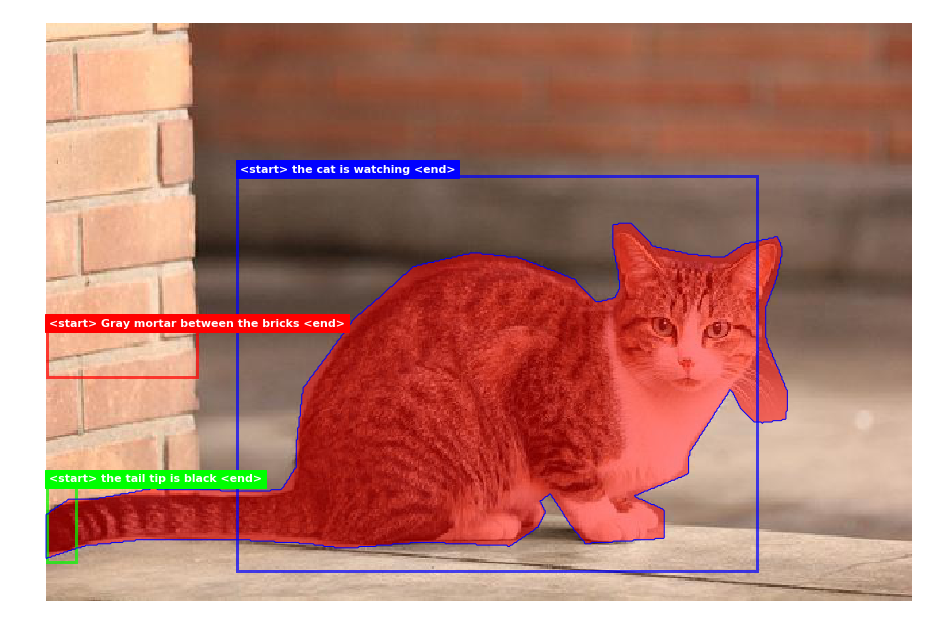

In [77]:
ann = random.choice(val_ann)
img_id = ann['image_id']
regions = ann['vg_ann']
coco_ann = ann['coco_ann']
print('Scale is {}'.format(ann['scale']))
bboxes = []
captions = []
for description in regions:
    x1, y1= description['x'], description['y']
    x2, y2 = x1 + description['width'], y1 + description['height']
    bbox = np.stack([x1, y1, x2, y2], axis=0)
    bboxes.append(bbox)
    captions.append(description['phrase'])
bboxes = np.stack(bboxes, axis=0)

bboxes, captions = filter_by_iou(bboxes, captions, threshold=0.0000000000001)
print(bboxes.shape[0])

masks = []
for cann in coco_ann:
    m = annToMask(cann, ann['image_height'], ann['image_width'])
    if m.max() < 1:
        continue
    # Is it a crowd? If so, use a negative class ID.
    if cann['iscrowd']:
        # For crowd masks, annToMask() sometimes returns a mask
        # smaller than the given dimensions. If so, resize it.
        if m.shape[0] != ann['image_height'] or m.shape[1] != ann['image_width']:
            m = np.ones([ann['image_height'], ann['image_width']], dtype=bool)
            continue
    masks.append(m)

masks = np.stack(masks, axis=2).astype(bool)

img = Image.open(os.path.join(COCOVG_ROOT, 'val/{}.jpg'.format(img_id)))
print('Open image in {}'.format(os.path.join(COCOVG_ROOT, 'val/{}.jpg'.format(img_id))))
image = img.convert("RGB")
image = np.array(image)
print(image.shape)
display_instances(image, bboxes, captions, masks)